<a href="https://colab.research.google.com/github/Dhaneesh02/fyp/blob/model_gfcc_chuncks_unaugmented/model_gfcc_chuncks_unaugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'
file_path_model = '/content/drive/MyDrive/Review_3/gfcc_chuncks_unaugmented/'

In [ ]:
### General imports ###
import os
from glob import glob
import pickle
import itertools
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline
### Graph imports ###
from PIL import Image
import librosa
### Audio import ###

import IPython
from IPython.display import Audio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
from dataclasses import dataclass
file = open(file_path+"filtered_annotations_msp_3500.csv")
csvreader = csv.reader(file)
header = next(csvreader)
# print(header)
csv_data = []
for row in csvreader:
    csv_data.append(row)

file.close()
labelling_data = dict()

for i in csv_data:
    labelling_data[i[0]]=i[1]
    
  
print(len(csv_data))

3500


In [ ]:
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence,detect_silence,detect_nonsilent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# # Start feature extraction
# print("Import Data: START")

# # Audio file path and names
# file_path_dataset = '/content/drive/MyDrive/Review_3/Data_msp_3500/'

# # Initialize features and labels list
# signal = []
# labels = []

# # Sample rate (16.0 kHz)
# sample_rate = 16000     

# # Max pad length (3.0 sec)
# max_pad_len = 49100


# file_names=[]

# #data_visualisation
# count = 0

# def find_breaking_duration(self, arr, threshold, step=2500, prev=0):
#   result =0 
#   for [i,j] in arr:
#     if(j<threshold):
#       result=j
#     else:
#       break
#   if (threshold-result) > 1000:
#     return prev+step
#   return result

# max_=0
# print("Import Data: RUNNING ... files")
# for i in labelling_data:
#   cur_file = file_path_dataset + i
#   y, sr = librosa.core.load(cur_file, sr=sample_rate, offset=0)
#   y = zscore(y)
#   # print(len(y))
#   file_ = AudioSegment.from_wav(cur_file)
#   #each chunck to hava a length of 3 sec
#   silence = detect_silence(file_, min_silence_len = 100, silence_thresh=-35)
#   # print(silence)
#   prev_breakpoint = 0
#   file_c = 0 
#   for j in range(2500, len(file_), 2500):
#     break_point = find_breaking_duration(arr = silence, threshold = j, prev = prev_breakpoint) 
#     if prev_breakpoint == 0:
#       y_padded = np.zeros(max_pad_len)
#       breakpoint = (breakpoint/1000)*16366 
#       y_padded[:breakpoint] = y[:breakpoint]
#     else:
#       y_padded = np.zeros(max_pad_len)
#       breakpoint = (breakpoint/1000)*16366
#       prev_breakpoint = (prev_breakpoint/1000)*16366
#       y_padded[prev_breakpoint:breakpoint] = y[prev_breakpoint:breakpoint]
#     prev_breakpoint = break_point
#     signal.append(y_padded)
#     labels.append(labelling_data[i])
#     temp_name = i[:-4]
#     file_names.append(temp_name+"_"+str(file_c)+".wav")
#     filr_c += 1
#   if count%400 == 0:
#     print(count,len(signal))
#   if count==3:
#     break
#   count += 1
# # Cast labels to array
# labels = np.asarray(labels).ravel()

# # Stop feature extraction
# print("Import Data: END \n")
# print("Number of audio files imported: {}".format(labels.shape[0]),"  ",count)


In [ ]:
# Start feature extraction
print("Import Data: START")

# Audio file path and names
file_path_dataset = '/content/drive/MyDrive/Review_3/Data_msp_3500/'

# Initialize features and labels list
signal = []
labels = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100


file_names=[]

#data_visualisation
count = 0

final_emo = {'Happy':0,'Sad':0,'Neutral':0,'Surprise':0,'Angry':0,'Disgust':0,'Fear':0}

max_=0
print("Import Data: RUNNING ... files")
for i in labelling_data:
  cur_file = file_path_dataset + i
  y, sr = librosa.core.load(cur_file, sr=sample_rate, offset=0)
  y = zscore(y)
  step = 2600
  file_ = AudioSegment.from_wav(cur_file)
  # print(len(file_))
  prev_breakpoint = 0
  file_c  = 0
  itr_c = 0
  for j in range(2600, len(file_), 2600):
    if j == step:
      y_padded = np.zeros(max_pad_len)
      breakpoint = round((j/1000)*16366) 
      inc = round((200/1000)*16366)
      y_padded[:breakpoint+inc] = y[:breakpoint+inc]
    else:
      breakpoint = round((j/1000)*16366)
      inc = round((200/1000)*16366)      
      y_temp = y[prev_breakpoint-inc:breakpoint+inc]
      y_padded = np.zeros(max_pad_len-len(y_temp))
      y_padded = np.concatenate((y_temp, y_padded))
    prev_breakpoint = breakpoint
    signal.append(y_padded)
    labels.append(labelling_data[i])
    final_emo[labelling_data[i]]+=1
    temp_name = i[:-4]
    file_names.append(temp_name+"_"+str(file_c)+".wav")
    file_c += 1
    itr_c += 1
    if itr_c == 3:
      break
  if count%100 == 0:
    print(count,len(signal))
  # if count==10:
  #   break
  count += 1
# Cast labels to array
labels = np.asarray(labels).ravel()

# Stop feature extraction
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]),"  ",count)
print(final_emo)

Import Data: START
Import Data: RUNNING ... files
0 3
100 300
200 597
300 897
400 1197
500 1495
600 1793
700 2090
800 2386
900 2685
1000 2985
1100 3285
1200 3583
1300 3883
1400 4180
1500 4477
1600 4773
1700 5068
1800 5364
1900 5659
2000 5954
2100 6252
2200 6548
2300 6842
2400 7136
2500 7430
2600 7723
2700 8015
2800 8306
2900 8593
3000 8883
3100 9170
3200 9463
3300 9763
3400 10056
Import Data: END 

Number of audio files imported: 10306    3500
{'Happy': 1500, 'Sad': 1500, 'Neutral': 1500, 'Surprise': 1500, 'Angry': 1500, 'Disgust': 1500, 'Fear': 1306}


In [ ]:
pickle.dump(signal, open(file_path_model+'signal.p', 'wb'))
pickle.dump(file_names, open(file_path_model+'file_names.p', 'wb'))
pickle.dump(labels, open(file_path_model+'labels.p', 'wb'))

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'

# Initialize features and labels list
signal = []
labels = []
file_names = []

# Sample rate (16.0 kHz)
sample_rate = 16000     

# Max pad length (3.0 sec)
max_pad_len = 49100


signal=pickle.load(open(file_path_model+"signal.p","rb"))
file_names=pickle.load(open(file_path_model+"file_names.p","rb"))
labels=pickle.load(open(file_path_model+"labels.p","rb"))

#data_visualisation
count = len(signal)
print("Import Data: END \n")
print("Number of audio files imported: {}".format(labels.shape[0]))

Import Data: END 

Number of audio files imported: 10306


In [ ]:
# # Number of augmented data
# nb_augmented = 1
# # Function to add noise to a signals with a desired Signal Noise ratio (SNR)
# def noisy_signal(signal, snr_low=15, snr_high=30, nb_augmented=1):
#     # Signal length
#     signal_len = len(signal)

#     # Generate White noise
#     noise = np.random.normal(size=(nb_augmented, signal_len))
    
#     # Compute signal and noise power
#     s_power = np.sum((signal / (2.0 ** 15)) ** 2) / signal_len
#     n_power = np.sum((noise / (2.0 ** 15)) ** 2, axis=1) / signal_len
    
#     # Random SNR: Uniform [15, 30]
#     snr = np.random.randint(snr_low, snr_high)
    
#     # Compute K coeff for each noise
#     K = np.sqrt((s_power / n_power) * 10 ** (- snr / 10))
#     K = np.ones((signal_len, nb_augmented)) * K
    
#     # Generate noisy signal
#     return signal + K.T * noise

In [ ]:
# # Generate noisy signals from signal list
# print("Data Augmentation: START")
# # augmented_signal = list(map(noisy_signal, signal))
# c=0
# print(len(signal))
# augmented_signal = []
# for i in signal:
#   augmented_signal.append(noisy_signal(i)[0])
#   if c%300==0:
#     print(c)
#   c+=1
# print("Data Augmentation: END!")
# print(len(augmented_signal))

Data Augmentation: START
10306
0
300
600
900
1200
1500
1800
2100
2400
2700
3000
3300
3600
3900
4200
4500
4800
5100
5400
5700
6000
6300
6600
6900
7200
7500
7800
8100
8400
8700
9000
9300
9600
9900
10200
Data Augmentation: END!
10306


In [ ]:
g=0
def mel_spectrogram(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000):
    global g
    if g%300==0:
      print(g) 
    g+=1
    # Compute spectogram
    mel_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    # Compute mel spectrogram
    mel_spect = librosa.feature.melspectrogram(S=mel_spect, sr=sr, n_mels=n_mels, fmax=fmax)
    
    # Compute log-mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    
    return mel_spect

In [ ]:
import gc

In [ ]:
#librosa.version.version=0.7.2
#spafe.sys.version=3.7.6 
!pip install spafe
import spafe
from librosa import display
from spafe.fbanks.gammatone_fbanks import gammatone_filter_banks


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 4.4 MB/s 


In [ ]:
def Log_Gammatone_Spectrum(y, sr=16000, n_fft=512, win_length=256, hop_length=128, window='hamming', n_mels=128, fmax=4000): 
    # y,sr=librosa.load(File_name,sr)
    gam_spect = np.abs(librosa.stft(y, n_fft=n_fft, window=window, win_length=win_length, hop_length=hop_length)) ** 2
    
    gammatone_filter_bank = gammatone_filter_banks(nfilts=128, nfft=512, fs=sr, low_freq=50, high_freq=None, scale='contsant', order=4)
    # print(gam_spect.shape,gammatone_filter_bank.shape)

    Gam=gammatone_filter_bank.dot(gam_spect)
    LogGamSpec = librosa.power_to_db(Gam,ref=np.max)
    # display.specshow(LogGamSpec,y_axis='log')
    return LogGamSpec

In [ ]:
# Start feature extraction
print("Feature extraction: START")

# Compute spectogram for all audio file
mel_spect = []
# print(len(signal),len(s))
for i in range(len(signal)):
  mel_spect.append(Log_Gammatone_Spectrum(signal[i]))


mel_spect = np.asarray(mel_spect)
del signal
gc.collect()

# Stop feature extraction
print("Feature extraction: END!")

Feature extraction: START
Feature extraction: END!


In [ ]:
pickle.dump(mel_spect, open(file_path_model+'mel_spect.p', 'wb'), protocol=4)


In [ ]:
# # Start feature extraction
# print("Feature extraction: START")

# augmented_mel_spect = []
# for i in range(len(augmented_signal)):
#   augmented_mel_spect.append(Log_Gammatone_Spectrum(augmented_signal[i]))
# augmented_mel_spect =  np.asarray(augmented_mel_spect)
# del augmented_signal
# gc.collect()

# # Stop feature extraction
# print("Feature extraction: END!")

In [ ]:

# print(mel_spect.shape)
# print(augmented_mel_spect.shape)
# print(labels.shape)

In [ ]:

# pickle.dump(augmented_mel_spect, open(file_path_model+'augmented_mel_spect.p', 'wb'), protocol=4)


In [ ]:
labels=pickle.load(open(file_path_model+"labels.p","rb"))

In [ ]:
# Build Train and test dataset
MEL_SPECT_train, MEL_SPECT_test,  label_train, label_test = train_test_split(mel_spect,  labels, test_size=0.2)
# MEL_SPECT_train, MEL_SPECT_test, AUG_MEL_SPECT_train, AUG_MEL_SPECT_test, label_train, label_test = train_test_split(mel_spect, augmented_mel_spect, labels, test_size=0.2)

# Build augmented labels and train
# aug_label_train = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_train])))
# AUG_MEL_SPECT_train = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_train)))
# AUG_MEL_SPECT_test = np.asarray(list(itertools.chain.from_iterable(AUG_MEL_SPECT_test)))
# aug_label_test = np.asarray(list(itertools.chain.from_iterable([[label] * nb_augmented for label in label_test])))
# print(AUG_MEL_SPECT_train.shape)
# print(AUG_MEL_SPECT_test.shape)
# Concatenate original and augmented
X_train = MEL_SPECT_train
y_train = label_train
# X_train = np.concatenate((MEL_SPECT_train, AUG_MEL_SPECT_train))
# y_train = np.concatenate((label_train, label_train))

print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
# Build test set
# X_test = np.concatenate((MEL_SPECT_test, AUG_MEL_SPECT_test))
X_test = MEL_SPECT_test
# y_test = np.concatenate((label_test, label_test))
y_test = label_test
print(X_test.shape)
print(y_test.shape)
# Delete
del MEL_SPECT_train,MEL_SPECT_test
# del MEL_SPECT_train, AUG_MEL_SPECT_train, label_train, AUG_MEL_SPECT_test, MEL_SPECT_test, label_test
del mel_spect, augmented_mel_spect, labels

x_train:  (8244, 128, 384)
y_train:  (8244,)
(2062, 128, 384)
(2062,)


NameError: ignored

In [ ]:
del MEL_SPECT_train,MEL_SPECT_test,signal

NameError: ignored

In [ ]:
win_ts = 128
hop_ts = 64

def frame(x, win_step=128, win_size=64):
    nb_frames = 1 + int((x.shape[2] - win_size) / win_step)
    frames = np.zeros((x.shape[0], nb_frames, x.shape[1], win_size)).astype(np.float32)
    for t in range(nb_frames):
        frames[:,t,:,:] = np.copy(x[:,:,(t * win_step):(t * win_step + win_size)]).astype(np.float32)
    return frames

X_train = frame(X_train, hop_ts, win_ts)
X_test = frame(X_test, hop_ts, win_ts)


In [ ]:

X_test.shape

(2062, 5, 128, 128)

In [ ]:
# Save Train and test set
pickle.dump(X_train.astype(np.float16), open(file_path_model+'[msp_mfcc][X_train].p', 'wb'))
pickle.dump(y_train, open(file_path_model+'[msp_mfcc][y_train].p', 'wb'))
pickle.dump(X_test.astype(np.float16), open(file_path_model+'[msp_mfcc][X_test].p', 'wb'))
pickle.dump(y_test, open(file_path_model+'[msp_mfcc][y_test].p', 'wb'))

In [ ]:
import os
from glob import glob
import pickle
import numpy as np
import pandas as pd
from keras.utils.vis_utils import plot_model
### Plot imports ###
from IPython.display import Image
import matplotlib.pyplot as plt

### Time Distributed ConvNet imports ###
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, TimeDistributed, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder

### Warning ###
import warnings
warnings.filterwarnings('ignore')

In [ ]:
file_path = '/content/drive/MyDrive/Review_3/'
file_path_model = '/content/drive/MyDrive/Review_3/gfcc_chuncks_unaugmented/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

X_train = pickle.load(open(file_path_model+'[msp_mfcc][X_train].p', 'rb'))
y_train = pickle.load(open(file_path_model+'[msp_mfcc][y_train].p', 'rb'))
y_test = pickle.load(open(file_path_model+'[msp_mfcc][y_test].p', 'rb'))
X_test = pickle.load(open(file_path_model+'[msp_mfcc][X_test].p', 'rb'))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) 

(8244, 5, 128, 128)
(8244,)
(2062, 5, 128, 128)
(2062,)


In [ ]:
print(file_path_model)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(np.ravel(y_train)))
y_test = np_utils.to_categorical(lb.transform(np.ravel(y_test)))

/content/drive/MyDrive/Review_3/gfcc_chuncks_unaugmented/


In [ ]:
# Reshape for convolution
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , X_train.shape[2], X_train.shape[3], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , X_test.shape[2], X_test.shape[3], 1)

In [ ]:
X_train.shape[1:]

(5, 128, 128, 1)

In [ ]:
K.clear_session()

input_y = Input(shape=X_train.shape[1:], name='Input_MELSPECT')

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'), name='Conv_1_MELSPECT')(input_y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_1_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_1_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), name='MaxPool_1_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_1_MELSPECT')(y)     

y = TimeDistributed(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_2_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_2_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_2_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_2_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_2_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_3_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_3_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_3_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_3_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_3_MELSPECT')(y)

y = TimeDistributed(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same'), name='Conv_4_MELSPECT')(y)
y = TimeDistributed(BatchNormalization(), name='BatchNorm_4_MELSPECT')(y)
y = TimeDistributed(Activation('elu'), name='Activ_4_MELSPECT')(y)
y = TimeDistributed(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'), name='MaxPool_4_MELSPECT')(y)
y = TimeDistributed(Dropout(0.2), name='Drop_4_MELSPECT')(y)  

y = TimeDistributed(Flatten(), name='Flat_MELSPECT')(y)                                           
# Apply 2 LSTM layer and one FC
y = LSTM(256, return_sequences=False, dropout=0.2, name='LSTM_1')(y)
y = Dense(y_train.shape[1], activation='softmax', name='FC')(y)

# Build final model
model = Model(inputs=input_y, outputs=y)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_MELSPECT (InputLayer)  [(None, 5, 128, 128, 1)]  0        
                                                                 
 Conv_1_MELSPECT (TimeDistri  (None, 5, 128, 128, 64)  640       
 buted)                                                          
                                                                 
 BatchNorm_1_MELSPECT (TimeD  (None, 5, 128, 128, 64)  256       
 istributed)                                                     
                                                                 
 Activ_1_MELSPECT (TimeDistr  (None, 5, 128, 128, 64)  0         
 ibuted)                                                         
                                                                 
 MaxPool_1_MELSPECT (TimeDis  (None, 5, 64, 64, 64)    0         
 tributed)                                                   

In [ ]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
# Compile model
model.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])

# Save best model
best_model_save = ModelCheckpoint(file_path_model+'msp_CNN_LSTM_Model_1.hdf5', save_best_only=True, monitor='accuracy', mode='max')

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=30, verbose=1, mode='max')

# Fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=125, validation_data=(X_test, y_test), callbacks=[early_stopping, best_model_save,tf.keras.callbacks.CSVLogger(file_path_model+'msp_gam_source_history_1.csv')])

Epoch 1/125
129/129 [==============================] - 34s 247ms/step - loss: 1.9638 - accuracy: 0.1543 - val_loss: 1.9470 - val_accuracy: 0.1581
Epoch 2/125
129/129 [==============================] - 30s 229ms/step - loss: 1.9384 - accuracy: 0.1670 - val_loss: 2.0229 - val_accuracy: 0.1571
Epoch 3/125
129/129 [==============================] - 30s 229ms/step - loss: 1.9277 - accuracy: 0.1853 - val_loss: 2.1585 - val_accuracy: 0.1494
Epoch 4/125
129/129 [==============================] - 30s 229ms/step - loss: 1.9153 - accuracy: 0.1963 - val_loss: 2.2264 - val_accuracy: 0.1552
Epoch 5/125
129/129 [==============================] - 29s 229ms/step - loss: 1.9054 - accuracy: 0.2038 - val_loss: 2.1296 - val_accuracy: 0.1503
Epoch 6/125
129/129 [==============================] - 30s 229ms/step - loss: 1.8973 - accuracy: 0.2118 - val_loss: 2.2857 - val_accuracy: 0.1532
Epoch 7/125
129/129 [==============================] - 30s 229ms/step - loss: 1.8914 - accuracy: 0.2159 - val_loss: 2.3938 -

In [ ]:
model.save(file_path_model+'msp_mfcc_[CNN-LSTM]Model_gfcc.h5')
model.save_weights(file_path_model+'msp_mfcc_[CNN-LSTM]Model_Weights_gfcc.h5')

In [ ]:
model.evaluate(X_test,y_test)

65/65 [==============================] - 2s 33ms/step - loss: 1.7760 - accuracy: 0.3244


[1.7759901285171509, 0.3244422972202301]

In [ ]:
y_pred=model.predict(X_test)
y_classes = y_pred.argmax(axis=-1)

In [ ]:
np.unique(y_classes)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
history={}
history["history"] = pd.read_csv(file_path_model+'msp_gam_source_history.csv')
history["history"].head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.154294,1.963778,0.158099,1.947025
1,1,0.167031,1.938429,0.157129,2.022937
2,2,0.185347,1.927721,0.149370,2.158496
3,3,0.196264,1.915265,0.155189,2.226440
4,4,0.203785,1.905400,0.150339,2.129636


Text(0, 0.5, 'Accuracy')

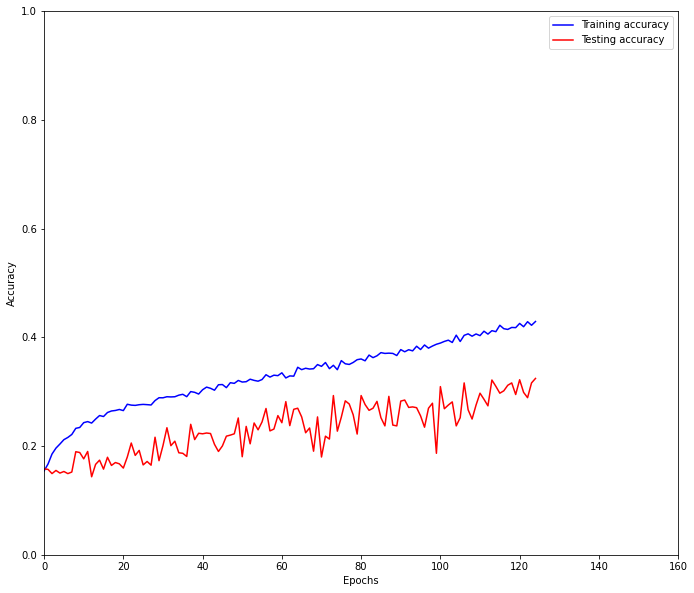

In [ ]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.plot(history['history']['accuracy'],'-b')
plt.plot(history['history']['val_accuracy'],'r')
plt.legend(['Training accuracy','Testing accuracy'])
plt.axis([0, 160, 0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [ ]:
# Importing all necessary libraries
from sklearn.metrics import accuracy_score
# Calculating the accuracy of classifier
print(f"Accuracy of the classifier is: {accuracy_score(y_test,y_pred1)}")

NameError: ignored

In [ ]:
y_test.shape

In [ ]:
y_pred.shape

In [ ]:
y_pred1=np.around(y_pred)
y_pred1

In [ ]:
y_pred1.shape

In [ ]:
gfcc_dict={"y_test_gfcc":y_test,"y_pred_gfcc":y_pred1}
gfcc_dict

In [ ]:
from sklearn.metrics import precision_score

# Calculating the precision score of classifier
print(f"Precision Score of the classifier is: {precision_score(y_test,y_pred1,average='micro')}")

In [ ]:
from sklearn.metrics import f1_score

# Calculating the F1 score of classifier
print(f"F1 Score of the classifier is: {f1_score(y_test, y_pred1,average='micro')}")

In [ ]:
y_pred1

In [ ]:
y_test

In [ ]:
y_test

In [ ]:
pickle.dump(gfcc_dict, open(file_path_model+'gfcc_dict_values.p', 'wb'))